### This part of the code contains the code to load and preprocssing the dataset

In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
import torchvision as tv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import wandb
import torch.optim as opt
from wandb import Api

transform = transforms.Compose([
    transforms.CenterCrop(224),  # or RandomResizedCrop(224)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


data = '/mnt/e_disk/DA24S008/DA6401_Assignment_2/dataset/inaturalist_12K' #This is the path to the dataset folder. I have kept inaturalist_12K folder inside a folder called dataset. when you are running this, copy paste the path of the "dataset" folder
trainset = ImageFolder(root=os.path.join(data, 'train'), transform=transform)
testset = ImageFolder(root=os.path.join(data, 'val'), transform=transform)


train_size = int(0.8 * len(trainset)) # I am keeping 80% of the actual training dataset for training and the remaining 20% will be for validation set.
val_size = len(trainset) - train_size

train_subset, val_subset = random_split(trainset, [train_size, val_size])

classes = trainset.classes

print(f"Classes: {classes}")
print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(testset)}")

Classes: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
Training samples: 7301
Validation samples: 1826
Test samples: 2000


### Question 1 (5 Marks)
Build a small CNN model consisting of $5$ convolution layers. Each convolution layer would be followed by an activation and a max-pooling layer. 

After $5$ such conv-activation-maxpool blocks, you should have one dense layer followed by the output layer containing $10$ neurons ($1$ for each of the $10$ classes). The input layer should be compatible with the images in the [iNaturalist dataset](https://storage.googleapis.com/wandb_datasets/nature_12K.zip) dataset.

The code should be flexible such that the number of filters, size of filters, and activation function of the convolution layers and dense layers can be changed. You should also be able to change the number of neurons in the dense layer.




In [ ]:
batch_size = 10
trainloader1 = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
class ConvNN(nn.Module):
    def __init__(self,
                 m =[16, 32, 64, 128, 256],
                 k=[3, 3, 3, 3, 3],
                 pool_params=[{'kernel_size': 2, 'stride': 2}]*5,
                 activations=[F.relu]*5,
                 dense_neurons=512,
                 dense_activation=F.relu,
                 num_classes=10):
        super(ConvNN, self).__init__()

        self.activations = activations
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()

        in_channels = 3
        for i in range(5):
            self.conv_layers.append(
                nn.Conv2d(in_channels, m[i], kernel_size=k[i])
            )
            in_channels = m[i]

            pool_config = pool_params[i]
            self.pool_layers.append(nn.MaxPool2d(**pool_config))

        sample_input, _ = next(iter(trainloader1)) 
        sample_image = sample_input[0].unsqueeze(0)

        with torch.no_grad():
            x = sample_image
            for i in range(5):
                x = self.pool_layers[i](self.activations[i](self.conv_layers[i](x)))
            conv_output_shape = x.numel()

        self.fc = nn.Linear(conv_output_shape, dense_neurons)
        self.fc_out = nn.Linear(dense_neurons, num_classes)
        self.dense_activation = dense_activation

    def forward(self, x):
        for i in range(5):
            x = self.pool_layers[i](self.activations[i](self.conv_layers[i](x)))
        x = torch.flatten(x, 1)
        x = self.dense_activation(self.fc(x))
        x = self.fc_out(x)
        return x


#Note: This code does not contain the wandb integration, I have kept it for easy running for question 1 of partA only. 

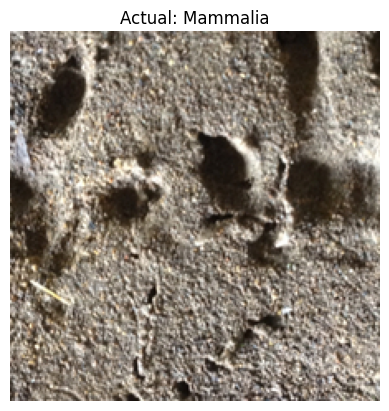

y   : Mammalia
y': Insecta


In [4]:
#The below piece of code contains the parameters of the 5 conv-activation-maxpool blocks and the dense layer.
model = ConvNN(
    m=[16, 32, 64, 128, 256], #Here we can customise the number of filters in each convolution layer. (ex: 1st convolution layer contains 16 filters and 2nd one has 32 and so on)
    k=[3, 3, 3, 3, 3], #Here we can customise the size of filters in each layer. I have kept all of them as 3X3 filters.
    pool_params=[
        {'kernel_size': 2, 'stride': 2}, #Filter size and Stride length for 1st maxpooling layer
        {'kernel_size': 3, 'stride': 2}, #Filter size and Stride length for 2nd maxpooling layer
        {'kernel_size': 2, 'stride': 1}, #Filter size and Stride length for 3rd maxpooling layer 
        {'kernel_size': 2, 'stride': 2}, #Filter size and Stride length for 4th maxpooling layer
        {'kernel_size': 3, 'stride': 2}, #Filter size and Stride length for 5th maxpooling layer
    ],
    dense_neurons=512,
    num_classes=10
)

#This code is for visualizing the output of the model's forward pass. The model is not yet trained, so the predictions are wrong. The training code is in the 2nd question's answer.
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(trainloader1)
images, labels = next(dataiter)
imshow(tv.utils.make_grid(images[0].unsqueeze(0)))
plt.title("Actual: " + classes[labels[0]])
plt.show()
model = ConvNN()
with torch.no_grad():
    outputs = model(images[0].unsqueeze(0))  # Add batch dimension
    _, predicted = torch.max(outputs, 1)

print(f"y   : {classes[labels[0]]}")
print(f"y': {classes[predicted[0]]}")

- What is the total number of computations done by your network? (assume $m$ filters in each layer of size $k\times k$  and $n$ neurons in the dense layer)

    Let the input images be N X N. Assuming m filters in each convolution layer, each filter is a k X k filter. Each convolution layer is followed by an activation and max pooling. There are 5 convolution layers, first layer maps from 3 channels (RGB) to m filters and the other 4 layers maps from m channels to m channels. We will assume the pooling layer also has the filter size of k X k. 

    Assuming no padding, and stride = 1, 

    - Spatial sizes after every layer:
            - After convolution "l" : N_(l-1)  X  N_(l-1), where l-1 denotes previous layer
            - After pooling l: N_l = N/k^l, where l = 1,2,3,4,5

    - Convolution computations:
        - For layer 1, input channels is 3 (RGB):

            - computation = m * (N^2) * (k^2 * 3) = 3 * m * k^2 * N^2

        - for layers 2 to 5, input channels will be m:

            - sum[m * ((N_(l-1))^2) * (k^2 * m)], where l goes from 2 to 5
                = m^2 * k^2 * N^2 * sum(1/(k^2i)), where the sum is over i = 1 to 4

        - total convolution computations:

            = 3 * m * k^2 * N^2 + m^2 * k^2 * N^2 * sum(1/(k^2i)), where the sum is over i = 1 to 4

    - Activation costs: 

        I am assuming ReLU

        - sum(m * (N_(l-1)^2)), where the sum is over l = 1 to 5.
                
            = m * N^2 * sum(1/k^2i), where the sum is over i = 0 to 4.

    - max pooling does not invove any computation as there is no multiplication or addition involved. 

    - Dense layer:

        - The dimension of the dense layer will be D = m * (N_5)^2 = m * (N^2)/(k^10)
        - A Single fully connected layer to n neurons costs D * n

            = m * n * (N^2)/(k^10)

    - Total computations would be the sum of all the above computations:

        = [3 * m * k^2 * N^2 + m^2 * k^2 * N^2 * sum_i(1/(k^2i))] +  [m * N^2 * sum_i(1/k^2i)] + [m * n * (N^2)/(k^10)]




- What is the total number of parameters in your network? (assume $m$ filters in each layer of size $k\times k$ and $n$ neurons in the dense layer)

    - m is the number of filters in each convolution layer
    - k is the filter size
    - Images are N X N dimensional
    - n is the number of neurons in the dense layer
    - C is the number of output classes
 
    - The number of parameters in first convolution layer: (convolution from 3 to m with k X k filter, + bias)

        = (3 * k^2) * m + m
        = 3 * m * k^2 + m
    
    - The number of parameters in convolution layers 2 to 5: (convolution from m to m with k X k filter, + bias)
        thre are 4 layers, so:

        = 4 * (m^2 * k^2) + m
        = (4 * m^2 * k^2) + (4 * m)

    - Dense layer: ((input is m*(N/k^5)^2), output = n, bias)

        = [n * (m * (N^2)/k^10)] + n

    - output layer: (n to C + bias)

        = C * n + C

    
    - Total number of parameters is the sum of all parameters:

        = [3 * m * k^2 + m] + [(4 * m^2 * k^2) + (4 * m)] + [[n * (m * (N^2)/k^10)] + n] + [C * n + C]



### Question 2 (15 Marks)
You will now train your model using the [iNaturalist dataset](https://storage.googleapis.com/wandb_datasets/nature_12K.zip). The zip file contains a train and a test folder. Set aside $20\%$ of the training data, as validation data, for hyperparameter tuning. Make sure each class is equally represented in the validation data. **Do not use the test data for hyperparameter tuning.**

Using the sweep feature in wandb find the best hyperparameter configuration. Here are some suggestions but you are free to decide which hyperparameters you want to explore

- number of filters in each layer : $32$, $64$, ...
- activation function for the conv layers: ReLU, GELU, SiLU, Mish, ...
- filter organisation: same number of filters in all layers, doubling in each subsequent layer, halving in each subsequent layer, etc
- data augmentation: Yes, No
- batch normalisation: Yes, No
- dropout: $0.2$, $0.3$ (BTW, where will you add dropout? You should read up a bit on this)

Based on your sweep please paste the following plots which are automatically generated by wandb:
- accuracy v/s created plot (I would like to see the number of experiments you ran to get the best configuration). 
- parallel co-ordinates plot
- correlation summary table (to see the correlation of each hyperparameter with the loss/accuracy)

Also, write down the hyperparameters and their values that you sweeped over. Smart strategies to reduce the number of runs while still achieving a high accuracy would be appreciated. Write down any unique strategy that you tried.

In [ ]:
activation_map = {
    'relu': F.relu,
    'gelu': F.gelu,
    'silu': F.silu,
    'mish': F.mish,
    'sigmoid': F.sigmoid
}

activation_module_map = {
    'relu': nn.ReLU,
    'gelu': nn.GELU,
    'silu': nn.SiLU,
    'mish': nn.Mish,
    'sigmoid': nn.Sigmoid
}

def init_weights(m, method):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if method == 'xavier':
            nn.init.xavier_uniform_(m.weight)
        else:
            nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def generate_filters(base_m, strategy):
    if strategy == 'same':
        return [base_m] * 5
    elif strategy == 'double':
        return [base_m * (2 ** i) for i in range(5)]
    elif strategy == 'half':
        return [max(1, base_m // (2 ** i)) for i in range(5)]

#I am redefining the network again with all the parameters that can be customisable with wandb configurations

class ConvNNconfig(nn.Module):
    def __init__(self, m, k=[3, 3, 3, 3, 3], pool_params=None,
                 activation='relu', dense_neurons=512, dropout=0.0,
                 batch_norm=False, num_classes=10):
        super(ConvNNconfig, self).__init__()
        if pool_params is None:
            pool_params = [{'kernel_size': 2, 'stride': 2}] * 5

        act_fn = activation_map[activation]
        act_module = activation_module_map[activation]

        self.layers = nn.ModuleList()
        in_channels = 3

        for i in range(5):
            conv_block = [nn.Conv2d(in_channels, m[i], kernel_size=k[i], padding=1)]
            if batch_norm:
                conv_block.append(nn.BatchNorm2d(m[i]))
            conv_block.append(act_module())
            if dropout > 0:
                conv_block.append(nn.Dropout2d(dropout))
            conv_block.append(nn.MaxPool2d(**pool_params[i]))

            self.layers.append(nn.Sequential(*conv_block))
            in_channels = m[i]

        self.flatten = nn.Flatten()

        with torch.no_grad():
            sample_image = torch.randn(1, 3, 224, 224)
            x = sample_image
            for block in self.layers:
                x = block(x)
            conv_output_shape = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(conv_output_shape, dense_neurons)
        self.fc2 = nn.Linear(dense_neurons, num_classes)
        self.act = act_module()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for block in self.layers:
            x = block(x)
        x = self.flatten(x)
        x = self.dropout(self.act(self.fc1(x)))
        return self.fc2(x)

def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config
        wandb.run.name = f"fo_{config.filter_org}/bn_{config.batch_norm}/act_{config.activation}/aug_{config.data_aug}"

        #The dataset preprocessing is already done in the first cell, but it is kind of hard coded. Here, I have made it such that the wandb config can be used for hyperparameter tuning.
        #Especially for data augmentation.
        if config.data_aug == 'yes':
            transform_train = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            transform_train = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])


        #No need of any augmentation for validation set.
        transform_val = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        data = '/mnt/e_disk/DA24S008/DA6401_Assignment_2/dataset/inaturalist_12K'

        #This is the complete training dataset provided by iNaturalist_12K
        full_trainset = ImageFolder(root=os.path.join(data, 'train'), transform=transform_train)
        
        #same as cell 1, we will split the dataset into training and validation sets. 

        train_size = int(0.8 * len(full_trainset))
        val_size = len(full_trainset) - train_size
        train_subset, val_subset = random_split(full_trainset, [train_size, val_size])

        trainloader = DataLoader(train_subset, batch_size=config.batch_size, shuffle=True, num_workers=2)
        valloader = DataLoader(val_subset, batch_size=config.batch_size, shuffle=False, num_workers=2)

        m = generate_filters(config.m, config.filter_org)

        model = ConvNNconfig(
            m=m,
            k=config.k,
            activation=config.activation,
            dropout=config.dropout,
            batch_norm=config.batch_norm == 'yes',
            num_classes=len(full_trainset.classes)
        )
        model.apply(lambda m: init_weights(m, config.weight_init))

        device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
        model.to(device)

        if config.optim_algo == 'sgd':
            optimizer = opt.SGD(model.parameters(), lr=config.lr)
        elif config.optim_algo == 'momentum':
            optimizer = opt.SGD(model.parameters(), lr=config.lr, momentum=0.9)
        elif config.optim_algo == 'adam':
            optimizer = opt.Adam(model.parameters(), lr=config.lr)
        elif config.optim_algo == 'nadam':
            optimizer = opt.NAdam(model.parameters(), lr=config.lr)
        elif config.optim_algo == 'nesterov':
            optimizer = opt.SGD(model.parameters(), lr=config.lr, momentum=0.9, nesterov=True)
        elif config.optim_algo == 'rmsprop':
            optimizer = opt.RMSprop(model.parameters(), lr=config.lr)

        criterion = nn.CrossEntropyLoss()

        for epoch in range(config.epochs):
            model.train()
            total_loss, correct, total = 0.0, 0, 0
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            train_acc = correct / total
            train_loss = total_loss / total

            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()

            val_acc = val_correct / val_total
            val_loss /= val_total

            best_val_acc = 0.0
            best_epoch = 0
            save_path = os.path.join(wandb.run.dir, 'best_model.pth')

            for epoch in range(config.epochs):
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_epoch = epoch + 1
                    torch.save(model.state_dict(), save_path)

                    artifact = wandb.Artifact('best-model', type='model')
                    artifact.add_file(save_path)
                    wandb.log_artifact(artifact)

            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc
            })

config_params = {
    'method': 'bayes',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [12, 15, 20]},
        'loss': {'values': ['cross_entropy']},
        'm': {'values': [32, 64, 128]},
        'k': {'values': [[5, 5, 5, 5, 5], [3, 3, 3, 3, 3], [5, 5, 5, 3, 3]]},
        'filter_org': {'values': ['same', 'double', 'half']},
        'optim_algo': {'values': ['sgd','momentum', 'adam']},
        'batch_size': {'values': [32, 64, 128]},
        'lr': {'values': [1e-2, 1e-3]},
        'data_aug': {'values': ['yes', 'no']},
        'batch_norm': {'values': ['yes', 'no']},
        'weight_init': {'values': ['random', 'xavier']},
        'dropout': {'values': [0.2, 0.3]},
        'activation': {'values': ['relu', 'gelu', 'silu', 'mish']},
    }
}

sweep_id = wandb.sweep(config_params, project='Assignment2')
wandb.agent(sweep_id, function=train_model, count=30)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: ppujb844
Sweep URL: https://wandb.ai/navaneeth001/Assignment2/sweeps/ppujb844


wandb: Agent Starting Run: sauv5377 with config:
wandb: 	activation: mish
wandb: 	batch_norm: yes
wandb: 	batch_size: 32
wandb: 	data_aug: no
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_org: half
wandb: 	k: [5, 5, 5, 5, 5]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 128
wandb: 	optim_algo: sgd
wandb: 	weight_init: xavier
wandb: Currently logged in as: navaneeth001 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Agent Starting Run: jqq3k0eq with config:
wandb: 	activation: gelu
wandb: 	batch_norm: yes
wandb: 	batch_size: 128
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_org: half
wandb: 	k: [5, 5, 5, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 64
wandb: 	optim_algo: sgd
wandb: 	weight_init: random


wandb: Agent Starting Run: vkmoez6f with config:
wandb: 	activation: gelu
wandb: 	batch_norm: no
wandb: 	batch_size: 32
wandb: 	data_aug: yes
wandb: 	dropout: 0.2
wandb: 	epochs: 12
wandb: 	filter_org: half
wandb: 	k: [3, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 32
wandb: 	optim_algo: momentum
wandb: 	weight_init: random


wandb: Agent Starting Run: 85jicn1n with config:
wandb: 	activation: gelu
wandb: 	batch_norm: no
wandb: 	batch_size: 128
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 12
wandb: 	filter_org: half
wandb: 	k: [3, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 32
wandb: 	optim_algo: sgd
wandb: 	weight_init: xavier


wandb: Agent Starting Run: afexyfab with config:
wandb: 	activation: mish
wandb: 	batch_norm: no
wandb: 	batch_size: 32
wandb: 	data_aug: no
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_org: half
wandb: 	k: [3, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 64
wandb: 	optim_algo: sgd
wandb: 	weight_init: xavier


wandb: Agent Starting Run: r4nxt3sg with config:
wandb: 	activation: silu
wandb: 	batch_norm: yes
wandb: 	batch_size: 128
wandb: 	data_aug: yes
wandb: 	dropout: 0.2
wandb: 	epochs: 12
wandb: 	filter_org: same
wandb: 	k: [5, 5, 5, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 128
wandb: 	optim_algo: momentum
wandb: 	weight_init: random


wandb: Agent Starting Run: 3nj8dqp2 with config:
wandb: 	activation: relu
wandb: 	batch_norm: yes
wandb: 	batch_size: 64
wandb: 	data_aug: yes
wandb: 	dropout: 0.2
wandb: 	epochs: 12
wandb: 	filter_org: half
wandb: 	k: [5, 5, 5, 5, 5]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 128
wandb: 	optim_algo: adam
wandb: 	weight_init: random


wandb: Agent Starting Run: rj077in3 with config:
wandb: 	activation: relu
wandb: 	batch_norm: yes
wandb: 	batch_size: 32
wandb: 	data_aug: no
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_org: double
wandb: 	k: [5, 5, 5, 5, 5]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 128
wandb: 	optim_algo: adam
wandb: 	weight_init: xavier


wandb: Agent Starting Run: wztr4o22 with config:
wandb: 	activation: mish
wandb: 	batch_norm: no
wandb: 	batch_size: 32
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 12
wandb: 	filter_org: same
wandb: 	k: [5, 5, 5, 5, 5]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 32
wandb: 	optim_algo: sgd
wandb: 	weight_init: random


wandb: Agent Starting Run: xyy5hwl6 with config:
wandb: 	activation: mish
wandb: 	batch_norm: no
wandb: 	batch_size: 128
wandb: 	data_aug: no
wandb: 	dropout: 0.2
wandb: 	epochs: 12
wandb: 	filter_org: double
wandb: 	k: [3, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 128
wandb: 	optim_algo: sgd
wandb: 	weight_init: xavier


wandb: Agent Starting Run: udfh9d1k with config:
wandb: 	activation: gelu
wandb: 	batch_norm: yes
wandb: 	batch_size: 64
wandb: 	data_aug: yes
wandb: 	dropout: 0.3
wandb: 	epochs: 12
wandb: 	filter_org: double
wandb: 	k: [3, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 32
wandb: 	optim_algo: momentum
wandb: 	weight_init: xavier


Traceback (most recent call last):
  File "/tmp/ipykernel_3339810/282323465.py", line 203, in train_model
    artifact.add_file(save_path)
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/_validators.py", line 115, in wrapper
    return method(self, *args, **kwargs)
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1333, in add_file
    return self._add_local_file(
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1598, in _add_local_file
    shutil.copyfile(path, staging_path)
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 267, in copyfile
    _fastcopy_sendfile(fsrc, fdst)
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 156, in _fastcopy_sendfile
    raise err from None
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 142, in _fastcopy_sendfile
    sent = os.sendfile(outfd, infd, offset, bloc

Run udfh9d1k errored:
Traceback (most recent call last):
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_3339810/282323465.py", line 203, in train_model
    artifact.add_file(save_path)
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/_validators.py", line 115, in wrapper
    return method(self, *args, **kwargs)
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1333, in add_file
    return self._add_local_file(
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1598, in _add_local_file
    shutil.copyfile(path, staging_path)
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 267, in copyfile
    _fastcopy_sendfile(fsrc, fdst)
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 156, in _fastcopy_sendfile
    raise err from Non

Traceback (most recent call last):
  File "/tmp/ipykernel_3339810/282323465.py", line 203, in train_model
    artifact.add_file(save_path)
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/_validators.py", line 115, in wrapper
    return method(self, *args, **kwargs)
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1333, in add_file
    return self._add_local_file(
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1598, in _add_local_file
    shutil.copyfile(path, staging_path)
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 267, in copyfile
    _fastcopy_sendfile(fsrc, fdst)
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 156, in _fastcopy_sendfile
    raise err from None
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 142, in _fastcopy_sendfile
    sent = os.sendfile(outfd, infd, offset, bloc

Run 238aghzl errored:
Traceback (most recent call last):
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "/tmp/ipykernel_3339810/282323465.py", line 203, in train_model
    artifact.add_file(save_path)
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/_validators.py", line 115, in wrapper
    return method(self, *args, **kwargs)
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1333, in add_file
    return self._add_local_file(
  File "/mnt/e_disk/da24s008/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 1598, in _add_local_file
    shutil.copyfile(path, staging_path)
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 267, in copyfile
    _fastcopy_sendfile(fsrc, fdst)
  File "/home/senai2/miniconda/anaconda/lib/python3.10/shutil.py", line 156, in _fastcopy_sendfile
    raise err from Non

wandb: Agent Starting Run: knorz849 with config:
wandb: 	activation: silu
wandb: 	batch_norm: no
wandb: 	batch_size: 128
wandb: 	data_aug: no
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_org: double
wandb: 	k: [3, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 64
wandb: 	optim_algo: adam
wandb: 	weight_init: random


wandb: Agent Starting Run: ylcmu9ru with config:
wandb: 	activation: mish
wandb: 	batch_norm: no
wandb: 	batch_size: 64
wandb: 	data_aug: yes
wandb: 	dropout: 0.3
wandb: 	epochs: 12
wandb: 	filter_org: double
wandb: 	k: [5, 5, 5, 5, 5]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 128
wandb: 	optim_algo: momentum
wandb: 	weight_init: random


wandb: Agent Starting Run: bbakxun6 with config:
wandb: 	activation: mish
wandb: 	batch_norm: no
wandb: 	batch_size: 32
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_org: same
wandb: 	k: [5, 5, 5, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 32
wandb: 	optim_algo: adam
wandb: 	weight_init: random


wandb: Agent Starting Run: gcygsx9m with config:
wandb: 	activation: silu
wandb: 	batch_norm: no
wandb: 	batch_size: 64
wandb: 	data_aug: yes
wandb: 	dropout: 0.2
wandb: 	epochs: 12
wandb: 	filter_org: half
wandb: 	k: [5, 5, 5, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 64
wandb: 	optim_algo: momentum
wandb: 	weight_init: random


wandb: Agent Starting Run: gnqj1we8 with config:
wandb: 	activation: relu
wandb: 	batch_norm: no
wandb: 	batch_size: 128
wandb: 	data_aug: no
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_org: double
wandb: 	k: [3, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 128
wandb: 	optim_algo: adam
wandb: 	weight_init: random


wandb: Agent Starting Run: d5fb7yje with config:
wandb: 	activation: gelu
wandb: 	batch_norm: no
wandb: 	batch_size: 64
wandb: 	data_aug: yes
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_org: half
wandb: 	k: [5, 5, 5, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 32
wandb: 	optim_algo: sgd
wandb: 	weight_init: random


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6lm3ast3 with config:
wandb: 	activation: gelu
wandb: 	batch_norm: no
wandb: 	batch_size: 64
wandb: 	data_aug: yes
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_org: half
wandb: 	k: [5, 5, 5, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 64
wandb: 	optim_algo: sgd
wandb: 	weight_init: xavier


wandb: Agent Starting Run: 85qi9rm2 with config:
wandb: 	activation: relu
wandb: 	batch_norm: yes
wandb: 	batch_size: 64
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 12
wandb: 	filter_org: double
wandb: 	k: [3, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 32
wandb: 	optim_algo: momentum
wandb: 	weight_init: random


wandb: Agent Starting Run: 183spe9g with config:
wandb: 	activation: silu
wandb: 	batch_norm: no
wandb: 	batch_size: 128
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 12
wandb: 	filter_org: same
wandb: 	k: [3, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 128
wandb: 	optim_algo: sgd
wandb: 	weight_init: xavier


wandb: Agent Starting Run: egnwe629 with config:
wandb: 	activation: gelu
wandb: 	batch_norm: yes
wandb: 	batch_size: 128
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_org: half
wandb: 	k: [3, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 128
wandb: 	optim_algo: adam
wandb: 	weight_init: random


wandb: Agent Starting Run: 42slq7ad with config:
wandb: 	activation: silu
wandb: 	batch_norm: no
wandb: 	batch_size: 128
wandb: 	data_aug: yes
wandb: 	dropout: 0.3
wandb: 	epochs: 15
wandb: 	filter_org: half
wandb: 	k: [5, 5, 5, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 128
wandb: 	optim_algo: adam
wandb: 	weight_init: random


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a0c0t3dd with config:
wandb: 	activation: mish
wandb: 	batch_norm: yes
wandb: 	batch_size: 128
wandb: 	data_aug: yes
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_org: half
wandb: 	k: [5, 5, 5, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 128
wandb: 	optim_algo: momentum
wandb: 	weight_init: xavier


wandb: Agent Starting Run: zte1rp2p with config:
wandb: 	activation: relu
wandb: 	batch_norm: yes
wandb: 	batch_size: 64
wandb: 	data_aug: no
wandb: 	dropout: 0.3
wandb: 	epochs: 12
wandb: 	filter_org: half
wandb: 	k: [5, 5, 5, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 32
wandb: 	optim_algo: momentum
wandb: 	weight_init: random


wandb: Agent Starting Run: t1v07qwf with config:
wandb: 	activation: silu
wandb: 	batch_norm: no
wandb: 	batch_size: 128
wandb: 	data_aug: yes
wandb: 	dropout: 0.3
wandb: 	epochs: 12
wandb: 	filter_org: half
wandb: 	k: [5, 5, 5, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 128
wandb: 	optim_algo: momentum
wandb: 	weight_init: random


wandb: Agent Starting Run: 4txi0pv4 with config:
wandb: 	activation: relu
wandb: 	batch_norm: yes
wandb: 	batch_size: 32
wandb: 	data_aug: yes
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	filter_org: same
wandb: 	k: [5, 5, 5, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 32
wandb: 	optim_algo: adam
wandb: 	weight_init: random


wandb: Agent Starting Run: lfzbjks2 with config:
wandb: 	activation: mish
wandb: 	batch_norm: no
wandb: 	batch_size: 32
wandb: 	data_aug: yes
wandb: 	dropout: 0.3
wandb: 	epochs: 12
wandb: 	filter_org: half
wandb: 	k: [3, 3, 3, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.01
wandb: 	m: 64
wandb: 	optim_algo: sgd
wandb: 	weight_init: random


wandb: Agent Starting Run: 3iea8jtw with config:
wandb: 	activation: gelu
wandb: 	batch_norm: yes
wandb: 	batch_size: 128
wandb: 	data_aug: no
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filter_org: same
wandb: 	k: [5, 5, 5, 3, 3]
wandb: 	loss: cross_entropy
wandb: 	lr: 0.001
wandb: 	m: 64
wandb: 	optim_algo: momentum
wandb: 	weight_init: random


### Question 3 (15 Marks)

- The top performing model was with ReLU as the activation followed by Silu
- Data Augmentation improves the model performance on the validation and test dataset
- Number of epochs also mattered in the training, longer epochs gave better results, but I was not able to check beyond 25 epochs due to compute constraints
- Dropout values were a bit confusing for me, as too low or too high values resulted in poor performance. After referring to sources, I understood that deactivating more number of neutrons reduces number of learnable parameters and hence degrades the performance, lesser number of dropouts should ideally improve training accuracy as might lead to overfitting, but it did not happen in my case, may be because the number of experiments are less for me to conclude this.
- Model performed poor on lesser batch sizes
- Having large filters (with k = 5) actually improved model performance.
- I also tried having bigger filters (k = 5) for first three layers and then smaller (k = 3) for last two layers, but k = 5 for all 5 layers performed better.
- Learning rate also impacted the model performance under a given epoch counts.


### Question 4 (5 Marks)
You will now apply your best model on the test data (You shouldn't have used test data so far. All the above experiments should have been done using train and validation data only). 

- Use the best model from your sweep and report the accuracy on the test set. 
- Provide a $10 \times 3$ grid containing sample images from the test data and predictions made by your best model (more marks for presenting this grid creatively).
- **(UNGRADED, OPTIONAL)** Visualise all the filters in the first layer of your best model for a random image from the test set. If there are 64 filters in the first layer plot them in an $8 \times 8$ grid. 
- **(UNGRADED, OPTIONAL)** Apply guided back-propagation on any $10$ neurons in the CONV5 layer and plot the images which excite this neuron. The idea again is to discover interesting patterns which excite some neurons. You will draw a $10 \times 1$ grid below with one image for each of the $10$ neurons. 

In [3]:
ENTITY   = 'navaneeth001'
PROJECT  = 'Assignment2'
SWEEP_ID = 'bga9ogah'
ARTIFACT_REF = 'navaneeth001/Assignment2/best-model:v197'

api      = Api()
sweep    = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
runs     = sweep.runs
best_run = max(runs, key=lambda r: r.summary.get('val_acc', 0))
cfg      = best_run.config

eval_run = wandb.init(
    project=PROJECT,
    entity=ENTITY,
    job_type='evaluation'
)

artifact = eval_run.use_artifact(ARTIFACT_REF, type='model')
download_dir = artifact.download()
model_path   = os.path.join(download_dir, 'best_model.pth')
print(f"Loaded model artifact to: {model_path}")

m_param      = cfg['m']
filter_org   = cfg.get('filter_org', 'same')
if isinstance(m_param, int):
    m_list = generate_filters(m_param, filter_org)
elif isinstance(m_param, (list, tuple)):
    m_list = list(m_param)
else:
    raise ValueError(f"Unsupported type for 'm': {type(m_param)}")

k_param = cfg['k'] 
if isinstance(k_param, int):
    k_sizes = [k_param] * len(m_list)
elif isinstance(k_param, (list, tuple)):
    k_sizes = list(k_param)
else:
    raise ValueError(f"Unsupported type for 'k': {type(k_param)}")

activation    = cfg.get('activation')
dropout       = cfg.get('dropout', 0.0)
batch_norm    = (cfg.get('batch_norm','no') == 'yes')
dense_neurons = cfg.get('dense_neurons', 512)
num_classes   = cfg.get('num_classes', 10)

model = ConvNNconfig(
    m=m_list,
    k=k_sizes,
    activation=activation,
    dropout=dropout,
    batch_norm=batch_norm,
    dense_neurons=dense_neurons,
    num_classes=num_classes
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
state  = torch.load(model_path, map_location=device)
model.load_state_dict(state)
model.to(device).eval()

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

data_path = '/mnt/e_disk/DA24S008/DA6401_Assignment_2/dataset/inaturalist_12K'
testset   = ImageFolder(root=os.path.join(data_path, 'val'), transform=transform_test)
testloader= DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total  += labels.size(0)
        correct+= (preds == labels).sum().item()

test_acc = 100.0 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

eval_run.finish()


wandb:   1 of 1 files downloaded.  


Loaded model artifact to: /mnt/e_disk/DA24S008/DA6401_Assignment_2/partA/artifacts/best-model:v197/best_model.pth
Test Accuracy: 28.50%


Now, to verify the performance of the model in a better way, I am training the model with the best model's hyperparameters for higher epochs and then test

In [7]:
best_config = {
    'epochs': 30,
    'm': 64,
    'k': [3, 3, 3, 3, 3],
    'filter_org': 'double',
    'optim_algo': 'momentum',
    'batch_size': 128,
    'lr': 0.01,
    'data_aug': 'no',
    'batch_norm': 'no',
    'weight_init': 'random',
    'dropout': 0.3,
    'activation': 'silu'
}

if best_config['data_aug'] == 'yes':
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
else:
    transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

data_path = '/mnt/e_disk/DA24S008/DA6401_Assignment_2/dataset/inaturalist_12K'
full_dataset = ImageFolder(root=os.path.join(data_path, 'train'), transform=transform_train)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
trainset, valset = random_split(full_dataset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=best_config['batch_size'], shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=best_config['batch_size'], shuffle=False, num_workers=2)

m = generate_filters(best_config['m'], best_config['filter_org'])
model = ConvNNconfig(
    m=m,
    k=best_config['k'],
    activation=best_config['activation'],
    dropout=best_config['dropout'],
    batch_norm=best_config['batch_norm'] == 'yes',
    num_classes=len(full_dataset.classes)

)
model.apply(lambda m: init_weights(m, best_config['weight_init']))

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
model.to(device)

if best_config['optim_algo'] == 'sgd':
    optimizer = opt.SGD(model.parameters(), lr=best_config['lr'])
elif best_config['optim_algo'] == 'momentum':
    optimizer = opt.SGD(model.parameters(), lr=best_config['lr'], momentum=0.9)
elif best_config['optim_algo'] == 'adam':
    optimizer = opt.Adam(model.parameters(), lr=best_config['lr'])

criterion = nn.CrossEntropyLoss()

for epoch in range(best_config['epochs']):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = total_loss / total
    epoch_acc = correct / total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{best_config['epochs']}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/30], Train Loss: 2.5212, Train Acc: 0.1735, Val Loss: 2.0330, Val Acc: 0.2875
Epoch [2/30], Train Loss: 2.0584, Train Acc: 0.2628, Val Loss: 1.9373, Val Acc: 0.3018
Epoch [3/30], Train Loss: 1.9708, Train Acc: 0.2965, Val Loss: 1.9037, Val Acc: 0.3231
Epoch [4/30], Train Loss: 1.9412, Train Acc: 0.3141, Val Loss: 1.9190, Val Acc: 0.3286
Epoch [5/30], Train Loss: 1.9114, Train Acc: 0.3271, Val Loss: 1.8687, Val Acc: 0.3330
Epoch [6/30], Train Loss: 1.8789, Train Acc: 0.3297, Val Loss: 1.8581, Val Acc: 0.3428
Epoch [7/30], Train Loss: 1.8632, Train Acc: 0.3345, Val Loss: 1.8579, Val Acc: 0.3461
Epoch [8/30], Train Loss: 1.8517, Train Acc: 0.3404, Val Loss: 1.8333, Val Acc: 0.3478
Epoch [9/30], Train Loss: 1.8042, Train Acc: 0.3636, Val Loss: 1.8325, Val Acc: 0.3390
Epoch [10/30], Train Loss: 1.8055, Train Acc: 0.3635, Val Loss: 1.7979, Val Acc: 0.3549
Epoch [11/30], Train Loss: 1.7885, Train Acc: 0.3620, Val Loss: 1.8063, Val Acc: 0.3571
Epoch [12/30], Train Loss: 1.7505, Train 

Now, we can test the above trained model with the test dataset:

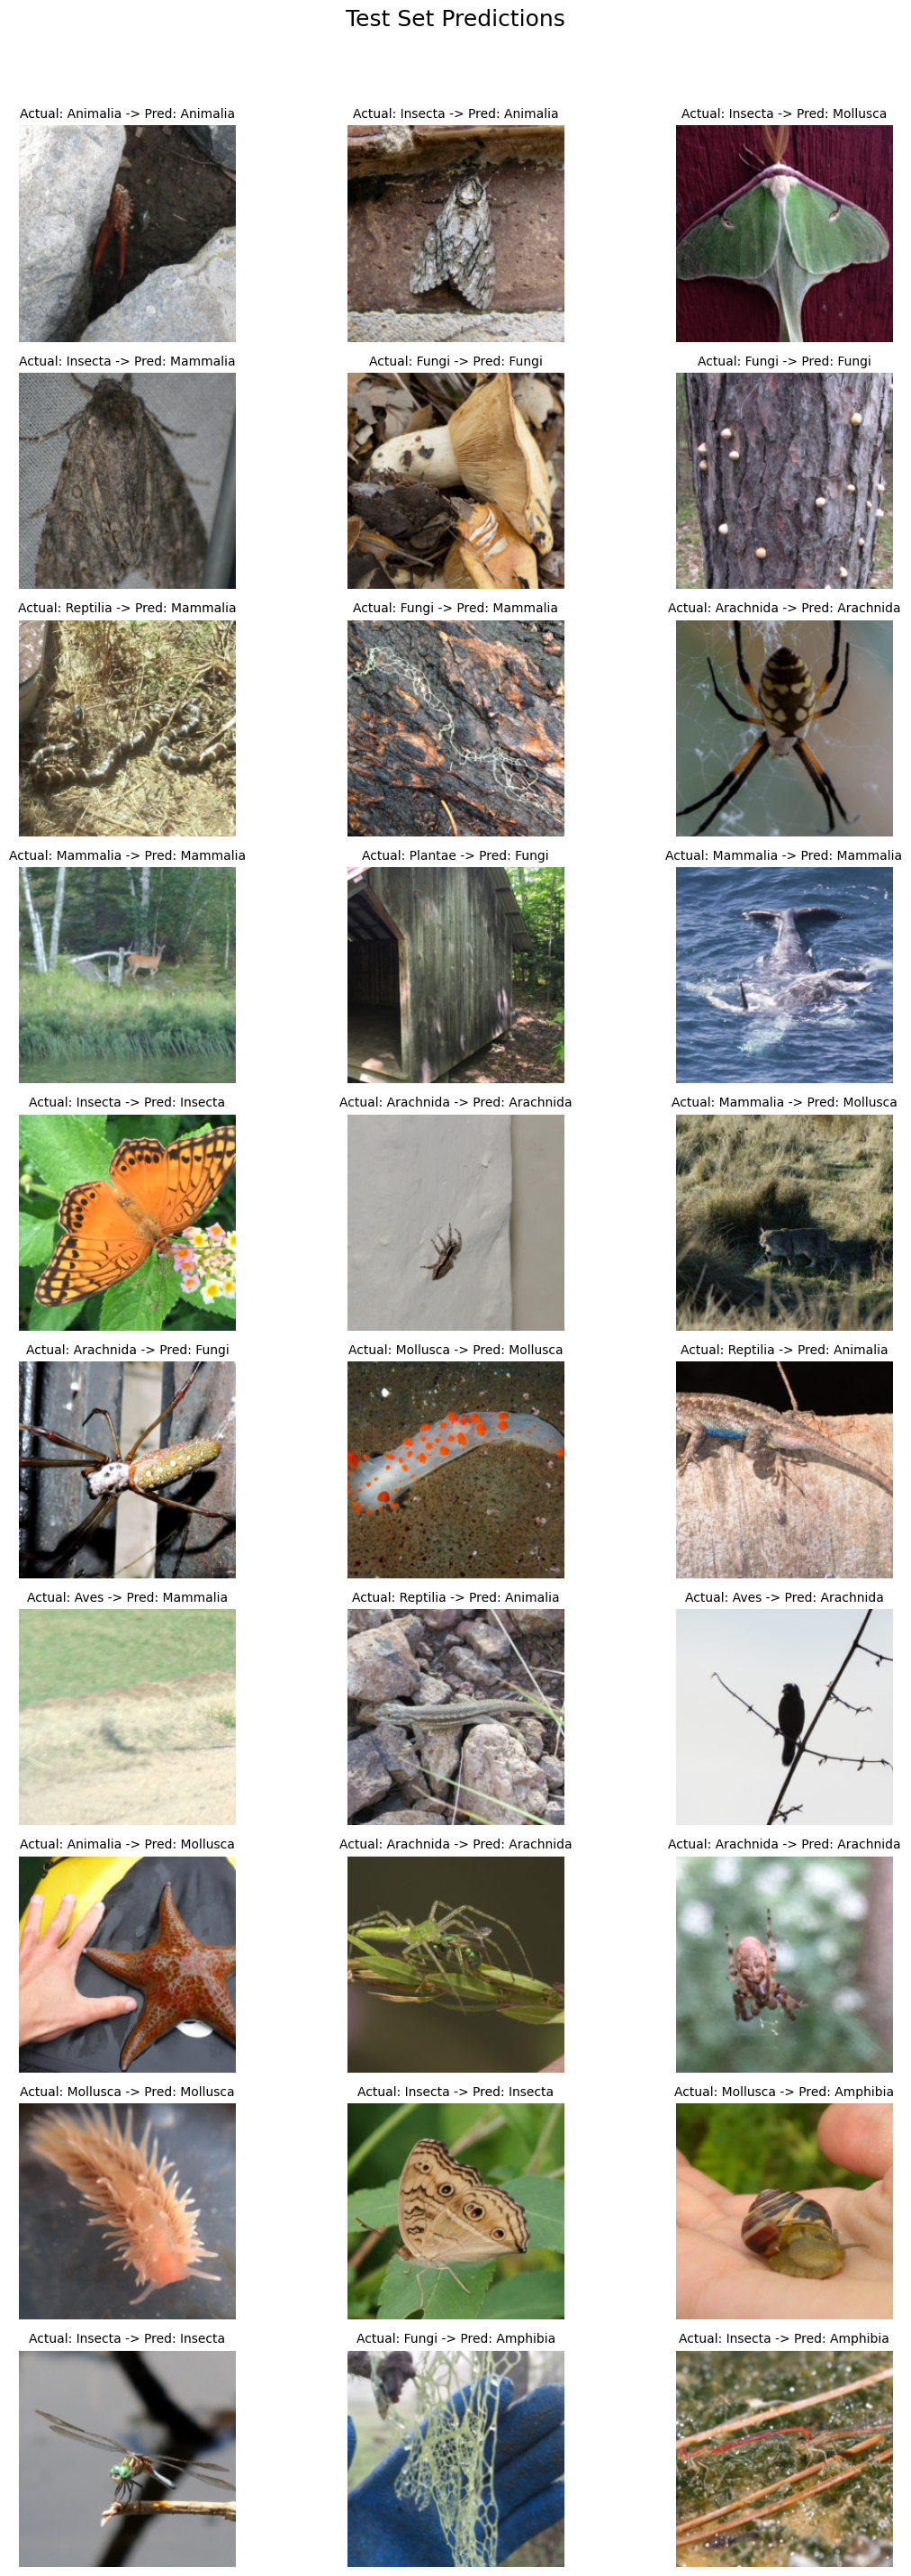

Test Accuracy: 0.3460


In [9]:
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = ImageFolder(root=os.path.join(data_path, 'val'), transform=transform_test)
testloader = DataLoader(testset, batch_size=best_config['batch_size'], shuffle=True, num_workers=2)
model.eval()
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = outputs.max(1)
class_names = testset.classes
fig, axes = plt.subplots(10, 3, figsize=(12, 28))
fig.suptitle("Test Set Predictions", fontsize=18, y=1.02)
images_cpu = images.cpu()
for i, ax in enumerate(axes.flat):
    img = images_cpu[i]
    img = img * 0.5 + 0.5 
    npimg = img.permute(1, 2, 0).numpy()
    ax.imshow(npimg)
    ax.set_title(f"Actual: {class_names[labels[i]]} -> Pred: {class_names[preds[i]]}", fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


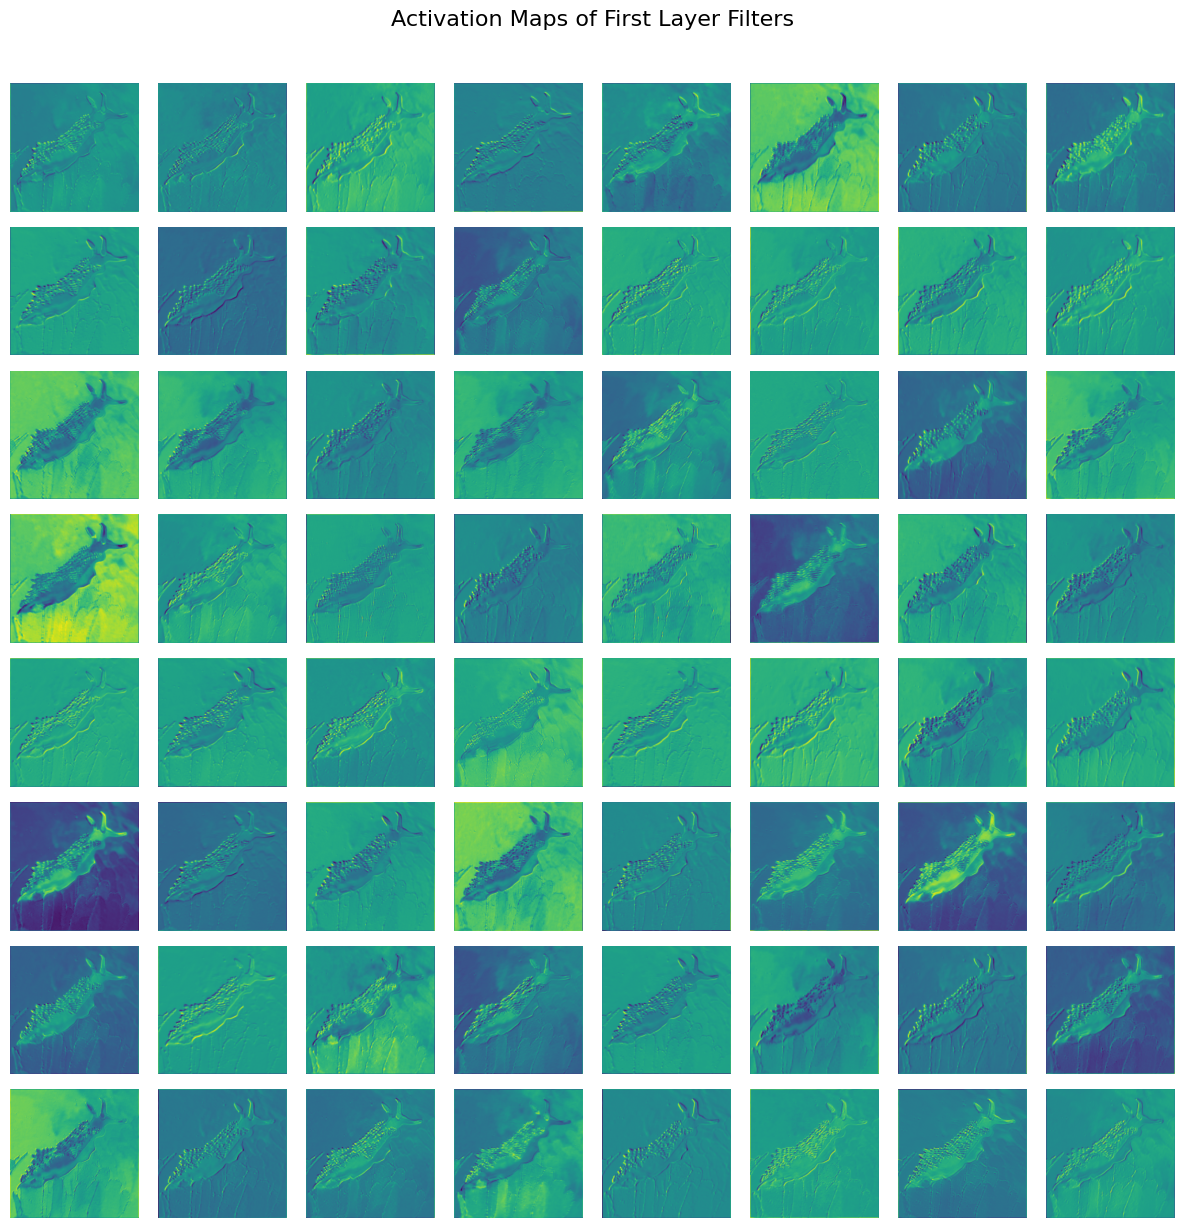

In [ ]:
#Optional
import random

random_idx = random.randint(0, len(testset) - 1)
sample_img, _ = testset[random_idx]
sample_img_batch = sample_img.unsqueeze(0).to(device)
first_conv_layer = None

for layer in model.modules():
    if isinstance(layer, nn.Conv2d):
        first_conv_layer = layer
        break


with torch.no_grad():
    first_conv_output = first_conv_layer(sample_img_batch)

activation_maps = first_conv_output.squeeze().cpu()
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
fig.suptitle("Activation Maps of First Layer Filters", fontsize=16, y=1.02)

for i, ax in enumerate(axes.flat):
    if i < activation_maps.shape[0]:
        ax.imshow(activation_maps[i], cmap='viridis')
    ax.axis('off')

plt.tight_layout()
plt.show()
